In [2]:
import json
import pandas as pd
import numpy as np
from scipy.io import loadmat
import requests
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
import matplotlib.pyplot as plt
%matplotlib inline

### Load data of other sets

In [3]:
coco_attributes = json.load(open('results/img_num_analysis/COCO-Attribute_image_per_attribute.json'))
sun_attributes = json.load(open('results/img_num_analysis/Sun-attribute_image_per_attribute.json'))
sun_scenes = json.load(open('results/img_num_analysis/Sun_image_per_scene.json'))
place_205scenes = json.load(open('results/img_num_analysis/Place-205_image_per_scene.json'))
coco_objects = json.load(open('results/img_num_analysis/MSCOCO_image_per_object.json'))
imageNet_objects = json.load(open('results/img_num_analysis/ImageNet_image_per_object.json'))

### Generate VizWiz data

In [4]:
with open('annotations/VizWiz/VizWiz_Captions_v1_train_updated.json') as f:
    data = json.load(f)
data = pd.DataFrame(data['annotations']).iloc[:,[0,2,-1]]
usefule_data = data[data['is_rejected']==0]
sentences = usefule_data.groupby('image_id')['caption'].apply(list).tolist()

In [5]:
stop_words = set(stopwords.words('english')) 
stop_words.update(['.',',','(',')','\'s'])

In [6]:
res_objects,res_scenes,res_attributes = {},{},{}

lemmatizer = WordNetLemmatizer()
for sentence in sentences:
    obj_set,scene_set,attr_set = set(),set(),set()
    for sent in sentence:
        if sent != 'Quality issues are too severe to recognize visual content.' and sent != 'A wonderful view of the fog windows in the room is very thick':
            sent = nltk.word_tokenize(sent.lower())
            #print(sent)
            words = [lemmatizer.lemmatize(w) for w in sent if not w in stop_words]
            for word in words:
                if word in coco_objects.keys() or word in imageNet_objects.keys():
                    obj_set.add(word)
                if word in sun_scenes.keys() or word in place_205scenes.keys():
                    scene_set.add(word)
                if word in coco_attributes.keys() or word in sun_attributes.keys():
                    attr_set.add(word)
    for word in obj_set:
        if word not in res_objects:
            res_objects[word] = 1
        else:
            res_objects[word] += 1
    for word in scene_set:
        if word not in res_scenes:
            res_scenes[word] = 1
        else:
            res_scenes[word] += 1
    for word in attr_set:
        if word not in res_attributes:
            res_attributes[word] = 1
        else:
            res_attributes[word] += 1
            #print(words)
#res_objects

In [7]:
json.dump(res_attributes,open('results/img_num_analysis/VizWiz_image_per_attribute.json','w'))
json.dump(res_objects,open('results/img_num_analysis/VizWiz_image_per_object.json','w'))
json.dump(res_scenes,open('results/img_num_analysis/VizWiz_image_per_scene.json','w'))

### Load VizWiz data

In [8]:
vizwiz_attributes = json.load(open('results/img_num_analysis/VizWiz_image_per_attribute.json'))
vizwiz_objects = json.load(open('results/img_num_analysis/VizWiz_image_per_object.json'))
vizwiz_scenes = json.load(open('results/img_num_analysis/VizWiz_image_per_scene.json'))

In [9]:
#Keep only the categories used in SUN and Place-205.
sun_scenes_397 = {}
place_205scenes_new = {}
for scene,num in sun_scenes.items():
    if num >= 100:
        sun_scenes_397[scene] = num

### Visualization

In [10]:
def draw_comparison(json1,json2,json3,num1,num2,num3,sortby,title,xlabel,max_num,savename):
    df_1 = pd.Series(json1).to_frame(num1).rename_axis('name').reset_index()
    df_2 = pd.Series(json2).to_frame(num2).rename_axis('name').reset_index()
    df_3 = pd.Series(json3).to_frame(num3).rename_axis('name').reset_index()
    df = df_1.merge(df_2,on='name').merge(df_3,on='name')
    df = df.sort_values(by=sortby,ascending=False).iloc[:max_num,:]
    plt.figure()
    plot = df.plot(figsize=(15,10),x="name", y=[num1,num2,num3],logy=True, kind="bar",fontsize=35)
    plot.legend(fontsize=30,loc='upper right')
    #plt.title('Comparison of Number of Images per %s'% title,fontsize=30)
    plt.xlabel('%s Categories'%xlabel,fontsize=30)
    plt.ylabel('Number of Images',fontsize=30)
    plt.savefig(savename,bbox_inches='tight')

<Figure size 432x288 with 0 Axes>

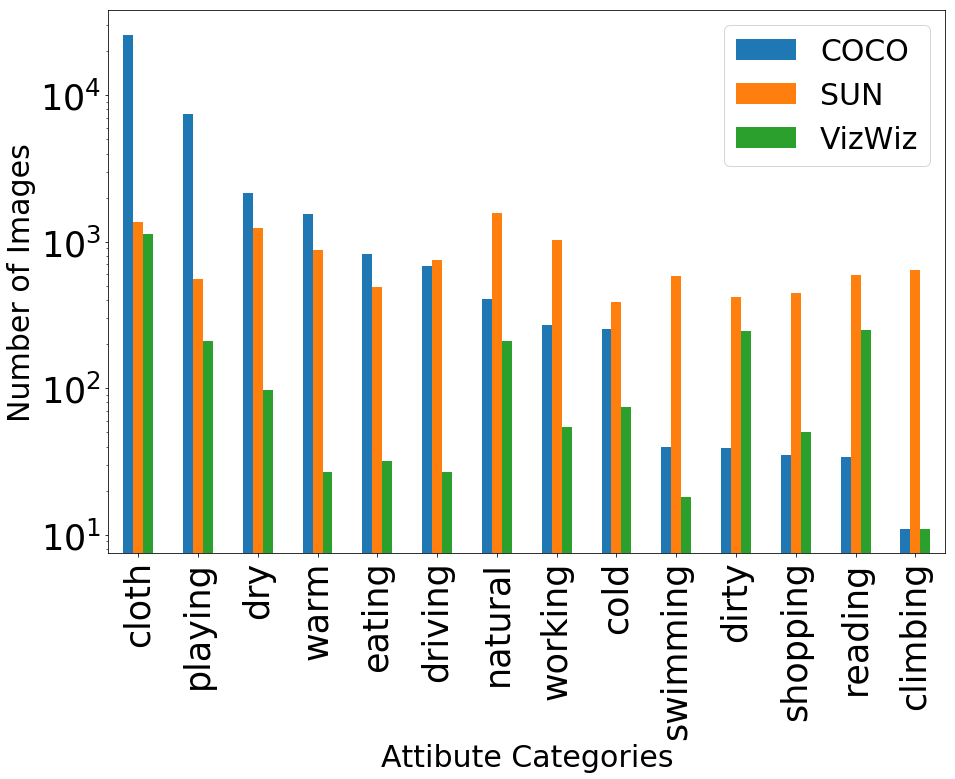

In [11]:
draw_comparison(coco_attributes,sun_attributes,vizwiz_attributes,'COCO','SUN','VizWiz','COCO','Attribute','Attibute',14,'results/img_num_analysis/attributeRecHistogram.png')

<Figure size 432x288 with 0 Axes>

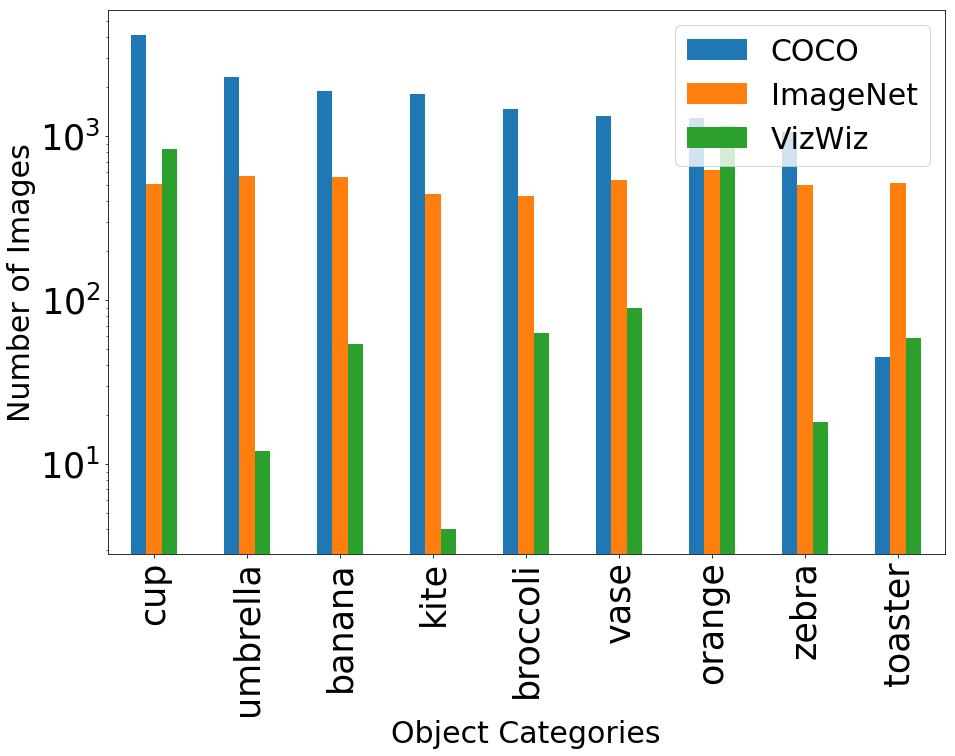

In [12]:
draw_comparison(coco_objects,imageNet_objects,vizwiz_objects,'COCO','ImageNet','VizWiz','COCO','Object','Object',9,'results/img_num_analysis/objRecHistogram.png')

<Figure size 432x288 with 0 Axes>

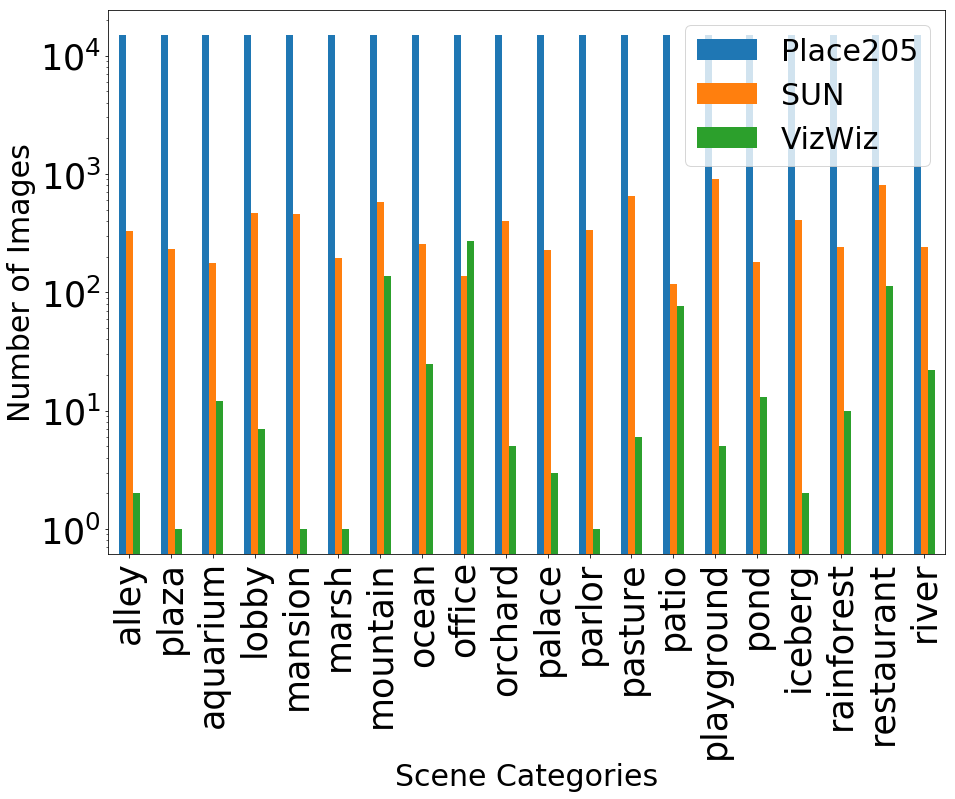

In [13]:
draw_comparison(place_205scenes,sun_scenes_397,vizwiz_scenes,'Place205','SUN','VizWiz','Place205','Scene','Scene',20,'results/img_num_analysis/sceneRecHistogram.png')